# 악플 분류기 - 다중분류
- 데이터: https://github.com/smilegate-ai/korean_unsmile_dataset

In [6]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [7]:
# 데이터 불러오기
train_df = pd.read_csv("/content/unsmile_train_v1.0.tsv",delimiter='\t')
test_df = pd.read_csv("/content/unsmile_valid_v1.0.tsv", delimiter='\t')

In [3]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(15005, 12) (3737, 12)


,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0


## 데이터 전처리

- train dataset

In [ ]:
# Null 값 체크
train_df.isna().sum().sum()

0

In [ ]:
# 중복 데이터 확인
train_df.shape, train_df.문장.nunique()

((15005, 12), 15004)

In [8]:
# 중복 데이터 제거
train_df.drop_duplicates(subset=['문장'], inplace=True)
train_df.shape

(15004, 12)

In [ ]:
# 분류가 안되어 있는 데이터 확인
train_df[train_df.sum(axis=1) == 0]

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
5876,혹시 돼지한명이랑 멸치 두명 무리 아니노 ㅋ 노천탕에서 자주봄 거기 사장들 달로 끊...,0,0,0,0,0,0,0,0,0,0,0
11942,누가 대통령이 지나가다가 여자 하나 성폭행했다고 고발해도 안했다는 증거 없으니 잡아...,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# 분류 안되어 있는 데이터 삭제
train_df = train_df[train_df.sum(axis=1) != 0]

- test dataset

In [ ]:
# Null 값 체크
test_df.isna().sum().sum()

0

In [ ]:
# 중복 데이터 확인
test_df.shape, test_df.문장.nunique()

((3737, 12), 3737)

In [ ]:
# 분류가 안되어 있는 데이터 확인
test_df[test_df.sum(axis=1) == 0]

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭


## 텍스트 전처리

- train data

In [10]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.문장 = train_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.문장.replace('', np.nan, inplace=True)
print(train_df.문장.isna().sum())
train_df.dropna(how='any', inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df.shape

24


(14978, 12)

- test data

In [11]:
# 한글 이외의 문자는 공백으로 처리하고 strip
test_df.문장 = test_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.문장.replace('', np.nan, inplace=True)
print(test_df.문장.isna().sum())
test_df.dropna(how='any', inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.shape

7


(3730, 12)

- 데이터 분포

In [ ]:
train_df.sum()[1:]

여성/가족    1599
남성       1347
성소수자     1140
인종/국적    1727
연령        603
지역       1052
종교       1181
기타 혐오     569
악플/욕설    3141
clean    3718
개인지칭      315
dtype: object

In [ ]:
test_df.sum()[1:]

여성/가족    393
남성       334
성소수자     280
인종/국적    426
연령       146
지역       260
종교       290
기타 혐오    134
악플/욕설    785
clean    930
개인지칭      74
dtype: object

## 악플 데이터만 학습

In [12]:
train_df = train_df[train_df['clean'] ==0]
test_df = test_df[test_df['clean'] ==0]

In [13]:
train_df = train_df.iloc[:, :10]
test_df = test_df.iloc[:, :10]

- 이중 레이블 나누기
- 레이블 열 생성

In [14]:
# 라벨링
df = pd.concat([train_df['문장'], train_df.iloc[:, 1:] * range(1, 10)], axis=1)

dataset_train = pd.DataFrame()
for i in range(1, 10):
  data = df.loc[df.iloc[:, i] > 0][['문장', df.columns[i]]]
  data.columns = ['문장', '라벨']
  dataset_train = pd.concat([dataset_train, data])
  
  dataset_train.reset_index(drop=True, inplace=True)

- 오버 샘플링

In [15]:
x = dataset_train['문장'].values.reshape(-1, 1)
y = dataset_train.iloc[:, 1:].values

In [16]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(x, y)

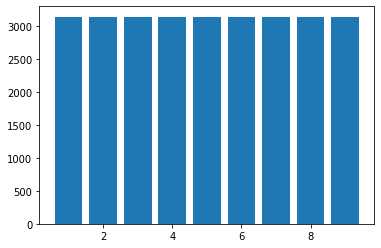

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

counter = Counter(y_resampled)
plt.bar(counter.keys(), counter.values())
plt.show()

## 한글 형태소 분석

In [19]:
# Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 16.89 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 671 kB/s 
     |████████████████████████████████| 453 kB 63.4 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-06-09 04:18:45--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (b

In [20]:
from konlpy.tag import Mecab
from tqdm.notebook import tqdm

In [21]:
mecab = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [22]:
train_data = []
for sentence in tqdm(X_resampled):
  morphs = mecab.morphs(sentence[0])
  tmp_X = [word for word in morphs if word not in stopwords]
  train_data.append(tmp_X)

  0%|          | 0/28269 [00:00<?, ?it/s]

In [23]:
test_data = []
for sentence in tqdm(test_df.문장):
  morphs = mecab.morphs(sentence)
  tmp_X = [word for word in morphs if word not in stopwords]
  test_data.append(tmp_X)

  0%|          | 0/2800 [00:00<?, ?it/s]

## 토큰화

In [24]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(train_data)

In [26]:
# 등장 빈도가 3 미만인 것의 갯수
threshold = 5
total_cnt = len(t.word_index)   # 단어의 수
rare_cnt = 0                    # 등장 빈도가 threshold 보다 작은 단어의 갯수
total_freq = 0                  # 훈련 데이터의 전체 단어의 빈도수의 합
rare_freq = 0                   # 등장 빈도가 threshold 보다 작은 단어의 등장 빈도수의 합

In [27]:
for key, value in t.word_counts.items():
  total_freq += value
  if value < threshold:
    rare_cnt += 1
    rare_freq += value

In [38]:
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17000
등장 빈도가 4번 이하인 희귀 단어의 수: 8990
단어 집합에서 희귀 단어의 비율: 52.88235294117647
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6434870822174976


In [28]:
# 모든 단어 사용
vocab_size = total_cnt + 2
vocab_size

17001

In [29]:
t = Tokenizer(num_words=vocab_size, oov_token='OOV')
t.fit_on_texts(train_data)
X_train = t.texts_to_sequences(train_data)
X_test = t.texts_to_sequences(test_data)

In [96]:
# 데이터의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(74, 18.202341787824118)

In [30]:
# 악플 길이를 60으로 설정
max_len = 60

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

X_train.shape, X_test.shape

((28269, 60), (2800, 60))

In [32]:
from tensorflow.keras.utils import to_categorical
# Y_train = train_df.iloc[:, 1:].values
Y_train = to_categorical(y_resampled)
Y_train = np.delete(Y_train, 0, 1)
Y_test = test_df.iloc[:, 1:].values
Y_train.shape, Y_test.shape

((28269, 9), (2800, 9))

## 모델 정의/설정/학습

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### 1. CNN
- Embedding Layer
- 2 One-Dimension Convolution Layers (Dropout: 50%)
- 1-Dimension Global Max Pooling
- Concatenate
- Fully Connected Layer
- 1-Dimension Fully Connected Layer
- Sigmoid Activation

In [ ]:
model1 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    Conv1D(64, 5, padding='valid', activation='relu', strides=1),
    Dropout(0.5),
    Conv1D(32, 5, padding='valid', activation='relu', strides=1),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(9, activation='softmax')
])
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 60, 128)           2176128   
                                                                 
 conv1d_6 (Conv1D)           (None, 56, 64)            41024     
                                                                 
 dropout_10 (Dropout)        (None, 56, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 52, 32)            10272     
                                                                 
 dropout_11 (Dropout)        (None, 52, 32)            0         
                                                                 
 global_max_pooling1d_6 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                     

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_path = 'best-cnn.h5py'
mc1 = ModelCheckpoint(model1_path, verbose=1, save_best_only=True)
es1 = EarlyStopping(patience=5)

In [ ]:
hist = model1.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=30, 
    batch_size=128,
    callbacks=[mc1, es1]
)

Epoch 1/30
171/177 [===========================>..] - ETA: 0s - loss: 1.9413 - accuracy: 0.2507
Epoch 1: val_loss improved from inf to 2.39377, saving model to best-cnn.h5py
INFO:tensorflow:Assets written to: best-cnn.h5py/assets
177/177 [==============================] - 3s 13ms/step - loss: 1.9283 - accuracy: 0.2572 - val_loss: 2.3938 - val_accuracy: 0.0000e+00
Epoch 2/30
172/177 [============================>.] - ETA: 0s - loss: 1.2159 - accuracy: 0.5798
Epoch 2: val_loss improved from 2.39377 to 2.20965, saving model to best-cnn.h5py
INFO:tensorflow:Assets written to: best-cnn.h5py/assets
177/177 [==============================] - 2s 12ms/step - loss: 1.2100 - accuracy: 0.5817 - val_loss: 2.2096 - val_accuracy: 0.1089
Epoch 3/30
171/177 [===========================>..] - ETA: 0s - loss: 0.8612 - accuracy: 0.7267
Epoch 3: val_loss improved from 2.20965 to 1.83348, saving model to best-cnn.h5py
INFO:tensorflow:Assets written to: best-cnn.h5py/assets
177/177 [=========================

In [ ]:
best_model1 = load_model(model1_path)
best_model1.evaluate(X_test, Y_test)

117/117 [==============================] - 0s 3ms/step - loss: 1.0104 - accuracy: 0.5394


[1.0103671550750732, 0.5394101738929749]

### 2. BiLSTM
- Embedding Layer
- Bidirectional LSTM (Dropout: 10%)
- 1-Dimension Global Max Pooling
- 1-Dimension Fully Connected Layer
- Sigmoid Activation

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
del model2

In [ ]:
model2 = Sequential([ 
    Embedding(vocab_size, 200, input_length=max_len),
    Bidirectional(LSTM(200, return_sequences=True)),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(9, activation='softmax')
])
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 60, 200)           3400200   
                                                                 
 bidirectional_5 (Bidirectio  (None, 60, 400)          641600    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 60, 400)           0         
                                                                 
 global_max_pooling1d_4 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 9)                 3609      
                                                                 
Total params: 4,045,409
Trainable params: 4,045,409
No

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_path = 'best-biLSTM.h5'
mc2 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=5)

In [ ]:
hist2 = model2.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc2,es2]
)

Epoch 1/30
176/177 [============================>.] - ETA: 0s - loss: 0.6188 - accuracy: 0.8098
Epoch 1: val_loss improved from inf to 1.33801, saving model to best-biLSTM.h5
177/177 [==============================] - 6s 34ms/step - loss: 0.6189 - accuracy: 0.8099 - val_loss: 1.3380 - val_accuracy: 0.4622
Epoch 2/30
175/177 [============================>.] - ETA: 0s - loss: 0.3736 - accuracy: 0.8721
Epoch 2: val_loss improved from 1.33801 to 1.08113, saving model to best-biLSTM.h5
177/177 [==============================] - 5s 26ms/step - loss: 0.3724 - accuracy: 0.8725 - val_loss: 1.0811 - val_accuracy: 0.6074
Epoch 3/30
177/177 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.8952
Epoch 3: val_loss improved from 1.08113 to 0.86459, saving model to best-biLSTM.h5
177/177 [==============================] - 4s 24ms/step - loss: 0.2783 - accuracy: 0.8952 - val_loss: 0.8646 - val_accuracy: 0.6942
Epoch 4/30
175/177 [============================>.] - ETA: 0s - loss: 0

In [ ]:
best_model2 = load_model(model2_path)
best_model2.evaluate(X_test, Y_test)

117/117 [==============================] - 1s 7ms/step - loss: 0.7850 - accuracy: 0.5601


[0.7849991917610168, 0.5600536465644836]

## 실제 데이터 예측

In [133]:
import re

In [132]:
def sentiment_predict(review, best_model,tokenizer=t, max_len=max_len):
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',review).strip()
    morphs = mecab.morphs(review)
    morphs = [word for word in morphs if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([morphs])
    padded = pad_sequences(encoded, maxlen=max_len)
    score = best_model.predict(padded)
    return score

In [ ]:
text = test_df['문장'][1]

In [ ]:
text = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',text).strip()
morphs = mecab.morphs(text)
morphs = [word for word in morphs if word not in stopwords]
encoded = t.texts_to_sequences([morphs])
padded = pad_sequences(encoded, maxlen=max_len)

In [ ]:
best_model2.predict(padded).argmax()

0

## 양방향 LSTM과 어텐션 메커니즘

In [45]:
import tensorflow as tf

In [46]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [62]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [60]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(9, activation="softmax")(dropout)
model3 = Model(inputs=sequence_input, outputs=output)
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 60, 128)      2176256     ['input_2[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 60, 128)     98816       ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  [(None, 60, 128),   98816       ['bidirectional_2[0][0]']  

In [65]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_path = 'best-lstm-attention.h5py'
mc3 = ModelCheckpoint(model3_path, verbose=1, save_best_only=True)
es3 = EarlyStopping(patience=3)

In [66]:
history = model3.fit(X_train, Y_train, epochs = 100, batch_size = 256, 
                     validation_data=(X_test, Y_test), verbose=1, 
                     callbacks=[mc3, es3])

Epoch 1/100
111/111 [==============================] - ETA: 0s - loss: 1.7949 - accuracy: 0.3586
Epoch 1: val_loss improved from inf to 1.78833, saving model to best-lstm-attention.h5py


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


111/111 [==============================] - 136s 1s/step - loss: 1.7949 - accuracy: 0.3586 - val_loss: 1.7883 - val_accuracy: 0.4682
Epoch 2/100
111/111 [==============================] - ETA: 0s - loss: 1.3785 - accuracy: 0.5276
Epoch 2: val_loss improved from 1.78833 to 1.52394, saving model to best-lstm-attention.h5py


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


111/111 [==============================] - 117s 1s/step - loss: 1.3785 - accuracy: 0.5276 - val_loss: 1.5239 - val_accuracy: 0.5875
Epoch 3/100
111/111 [==============================] - ETA: 0s - loss: 1.1423 - accuracy: 0.6156
Epoch 3: val_loss improved from 1.52394 to 1.42450, saving model to best-lstm-attention.h5py


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


111/111 [==============================] - 116s 1s/step - loss: 1.1423 - accuracy: 0.6156 - val_loss: 1.4245 - val_accuracy: 0.6014
Epoch 4/100
111/111 [==============================] - ETA: 0s - loss: 0.9916 - accuracy: 0.6795
Epoch 4: val_loss improved from 1.42450 to 1.35825, saving model to best-lstm-attention.h5py


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


111/111 [==============================] - 118s 1s/step - loss: 0.9916 - accuracy: 0.6795 - val_loss: 1.3582 - val_accuracy: 0.6361
Epoch 5/100
111/111 [==============================] - ETA: 0s - loss: 0.8796 - accuracy: 0.7184
Epoch 5: val_loss did not improve from 1.35825
111/111 [==============================] - 66s 599ms/step - loss: 0.8796 - accuracy: 0.7184 - val_loss: 1.3929 - val_accuracy: 0.6400
Epoch 6/100
111/111 [==============================] - ETA: 0s - loss: 0.7713 - accuracy: 0.7569
Epoch 6: val_loss improved from 1.35825 to 1.34572, saving model to best-lstm-attention.h5py


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


INFO:tensorflow:Assets written to: best-lstm-attention.h5py/assets


111/111 [==============================] - 117s 1s/step - loss: 0.7713 - accuracy: 0.7569 - val_loss: 1.3457 - val_accuracy: 0.6625
Epoch 7/100
111/111 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.7810
Epoch 7: val_loss did not improve from 1.34572
111/111 [==============================] - 66s 596ms/step - loss: 0.6949 - accuracy: 0.7810 - val_loss: 1.4965 - val_accuracy: 0.6654
Epoch 8/100
111/111 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.7952
Epoch 8: val_loss did not improve from 1.34572
111/111 [==============================] - 66s 592ms/step - loss: 0.6324 - accuracy: 0.7952 - val_loss: 1.6802 - val_accuracy: 0.6614
Epoch 9/100
111/111 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.8014
Epoch 9: val_loss did not improve from 1.34572
111/111 [==============================] - 66s 593ms/step - loss: 0.6061 - accuracy: 0.8014 - val_loss: 1.6040 - val_accuracy: 0.6639


In [67]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, Y_test)[1]))

88/88 [==============================] - 6s 64ms/step - loss: 1.2746 - accuracy: 0.6718

 테스트 정확도: 0.6718


## 셀프 어텐션

### 멀티 헤드 어텐션
- 트랜스포머 인코더의 첫번째 서브층

In [2]:
import tensorflow as tf

In [3]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

### 인코더 설계하기
- 두번째 서브칭인 포지션 와이즈 피드 포워드 신경망 추가

In [4]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

### 포지션 임베딩
- 임베딩 층을 사용하되, 위치 벡터 학습하도록 임베딩 층의 첫번째 인자로 단어 집합의 크기가 아니라 문장의 최대 길이를 넣어줌

In [5]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### 데이터 전처리

In [33]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

### 모델 정의/학습

In [41]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [63]:
del model

In [64]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(9, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 60)]              0         
                                                                 
 token_and_position_embeddin  (None, 60, 32)           545952    
 g_11 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_11 (Trans  (None, 60, 32)           6464      
 formerBlock)                                                    
                                                                 
 global_max_pooling1d_9 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_38 (Dropout)        (None, 32)                0   

In [65]:
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
model_path = 'best-transforemr-attention.h5py'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=3)

history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_test, Y_test), callbacks=[mc, es])

Epoch 1/100
884/884 [==============================] - ETA: 0s - loss: 1.6337 - accuracy: 0.4292
Epoch 1: val_loss improved from inf to 1.14289, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


884/884 [==============================] - 11s 11ms/step - loss: 1.6337 - accuracy: 0.4292 - val_loss: 1.1429 - val_accuracy: 0.7125
Epoch 2/100
883/884 [============================>.] - ETA: 0s - loss: 0.7786 - accuracy: 0.7576
Epoch 2: val_loss improved from 1.14289 to 0.99249, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


884/884 [==============================] - 10s 11ms/step - loss: 0.7783 - accuracy: 0.7577 - val_loss: 0.9925 - val_accuracy: 0.7386
Epoch 3/100
877/884 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.8362
Epoch 3: val_loss did not improve from 0.99249
884/884 [==============================] - 7s 7ms/step - loss: 0.5141 - accuracy: 0.8361 - val_loss: 1.0724 - val_accuracy: 0.7089
Epoch 4/100
881/884 [============================>.] - ETA: 0s - loss: 0.3973 - accuracy: 0.8680
Epoch 4: val_loss did not improve from 0.99249
884/884 [==============================] - 7s 7ms/step - loss: 0.3970 - accuracy: 0.8679 - val_loss: 1.1899 - val_accuracy: 0.7300
Epoch 5/100
880/884 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8801
Epoch 5: val_loss did not improve from 0.99249
884/884 [==============================] - 7s 7ms/step - loss: 0.3386 - accuracy: 0.8802 - val_loss: 1.2931 - val_accuracy: 0.7204


In [66]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

88/88 [==============================] - 1s 4ms/step - loss: 0.9925 - accuracy: 0.7386


[0.9924857020378113, 0.7385714054107666]

In [67]:
import re

def sentiment_predict(review, best_model,tokenizer=t, max_len=max_len):
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',review).strip()
    morphs = mecab.morphs(review)
    morphs = [word for word in morphs if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([morphs])
    padded = pad_sequences(encoded, maxlen=max_len)
    score = best_model.predict(padded)
    class_text = test_df.columns[1:]

    return print(f"'{review}'\n {score[0][score.argmax()]*100}%의 확률로 {class_text[score.argmax()]}에 대한 악플입니다.")

In [75]:
text = test_df['문장'][23]
sentiment_predict(text, best_model,tokenizer=t, max_len=max_len)

'야이 점쟁이새끼야 더러운글 그만올리고점사나 잘봐라'
 91.53352379798889%의 확률로 악플/욕설에 대한 악플입니다.


In [74]:
review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',text).strip()
morphs = mecab.morphs(review)
morphs = [word for word in morphs if word not in stopwords]
encoded = t.texts_to_sequences([morphs])
padded = pad_sequences(encoded, maxlen=max_len)
score = best_model.predict(padded)
score

array([[0.20046328, 0.27338484, 0.04363228, 0.14791888, 0.03756335,
        0.07241045, 0.02485918, 0.17876512, 0.02100265]], dtype=float32)

In [217]:
class_text = test_df.columns[1:]
class_text

Index(['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설'], dtype='object')